In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from scipy.stats import chi2_contingency

In [2]:
df = pd.read_excel('Finalise.xlsx')

In [4]:
df

,Date,Sales in Country,Product ID,Quantity in Kg,Product Name,Category,Sub-Category,Base Unit,KG per Each,Each Per Carton,Carton Per Pallet,Shelf Life In Days,Storage Condition,Temperature Condition,Country of Origin,KG per Pallet,Year,Month,Quarter,Trade
0,2021-08-02,Malaysia,103033,1485.000000,"Authentic Greek-Style Yogurt, Mango 450ML x 4",Yogurt,Greek-Style Yogurt,PACK,0.450000,4.0,220.0,45,Chilled,+6 Degrees,Malaysia,396.000,2021,8,3,Domestic
1,2021-08-02,Malaysia,111980,32.000000,"Low Fat Skim Milk Powder, Unsweetened 1KG x 8",Powder,Skim Milk Powder,CAR,1.000000,8.0,48.0,364,Ambient,Ambient,Netherlands,384.000,2021,8,3,International
2,2021-08-02,Malaysia,103036,919.800000,"Smooth Traditional Yogurt, Mixed Fruit 450ML x 4",Yogurt,Traditional Yogurt,PACK,0.450000,4.0,220.0,45,Chilled,+6 Degrees,Malaysia,396.000,2021,8,3,Domestic
3,2021-08-02,Thailand,103038,5940.000000,"Smooth Traditional Yogurt, Mixed Fruit 450ML x 4",Yogurt,Traditional Yogurt,PACK,0.450000,4.0,220.0,45,Chilled,+6 Degrees,Thailand,396.000,2021,8,3,Domestic
4,2021-08-02,Singapore,102123,72.000000,"Classic Dairy Blend Spread, Original Flavor 2...",Butter Fats And Spreads,Blends & Dairy Spreads,CAR,0.250000,12.0,144.0,182,Chilled,+2 Degrees,New Zealand,432.000,2021,8,3,International
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23029,2024-03-30,France,124951,1733.200000,"Aged Cheddar Cheese Block, Extra Sharp 400G x 7",Cheese,Block Cheese,CAR,0.400000,7.0,288.0,270,Chilled,+2 Degrees,Australia,806.400,2024,3,1,International
23030,2024-03-30,France,124952,1728.000000,"Sliced Swiss Cheese, Mild 1.5KG x 8",Cheese,Natural Cheese Slices,CAR,1.500000,8.0,63.0,213,Chilled,+2 Degrees,Netherlands,756.000,2024,3,1,International
23031,2024-03-30,France,310421,140.134667,"Fresh Whipping Cream, Natural 303ML x 12",Consumer Dairy Liquid,Fresh Cream,CAR,0.302667,12.0,168.0,30,Chilled,+2 Degrees,Netherlands,610.176,2024,3,1,International
23032,2024-03-30,France,103032,360.000000,"Creamy Greek-Style Yogurt, Blueberry 450ML x 4",Yogurt,Greek-Style Yogurt,PACK,0.450000,4.0,220.0,45,Chilled,+6 Degrees,Netherlands,396.000,2024,3,1,International


In [7]:
df[df['Quantity in Kg'] > 0].to_excel('Finalise02.xlsx', index=False)

In [32]:
df = pd.read_excel('output.xlsx')
sea_data = df[df['Markets']=='Southeast Asian']
sea_aggregated_data = sea_data.groupby('Date')['Quantity in Kg'].sum().reset_index()

In [36]:
df['Trade'] = np.where(df['Country of Origin'] == df['Sales in Country'], 'Domestic', 'International')
df.to_excel('Finalise.xlsx', index=False)

In [14]:
# Correctly compile and present the outlier summary for each column
columns_to_check = ['Quantity in Kg', 'KG per Each', 'Each Per Carton', 'Carton Per Pallet', 'Shelf Life In Days', 'KG per Pallet']
outlier_summaries = {}

for column in columns_to_check:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter out the outlier values
    outliers_data = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    outlier_summary = {
        "Count of Outliers": outliers_data.shape[0],
        "Minimum Outlier Value": outliers_data[column].min(),
        "Maximum Outlier Value": outliers_data[column].max()
    }
    outlier_summaries[column] = outlier_summary

outlier_summaries_df = pd.DataFrame(outlier_summaries).T
outlier_summaries_df

,Count of Outliers,Minimum Outlier Value,Maximum Outlier Value
Quantity in Kg,2179.0,1634.4,27494.24472
KG per Each,4034.0,1.4,15.00000
Each Per Carton,619.0,250.0,250.00000
Carton Per Pallet,0.0,NaN,NaN
Shelf Life In Days,891.0,729.0,729.00000
KG per Pallet,0.0,NaN,NaN


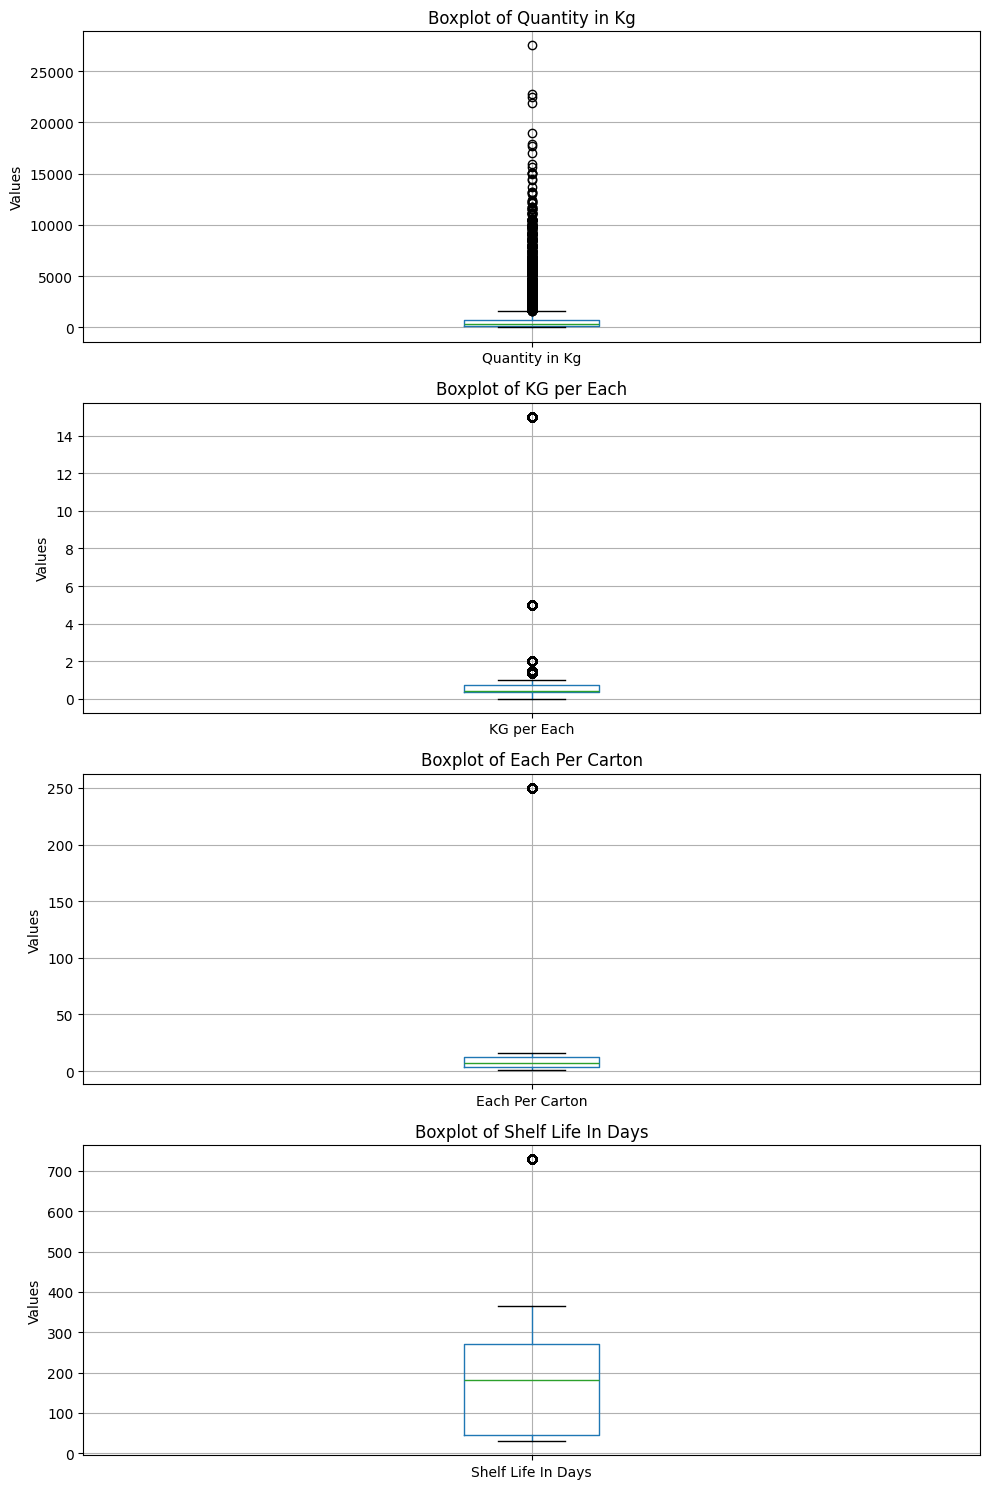

In [16]:
# Selecting columns where outliers were found
columns_with_outliers = ['Quantity in Kg', 'KG per Each', 'Each Per Carton', 'Shelf Life In Days']

fig, axes = plt.subplots(nrows=len(columns_with_outliers), figsize=(10, 15))

for i, col in enumerate(columns_with_outliers):
    df.boxplot(column=[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_ylabel('Values')

plt.tight_layout()
plt.show()

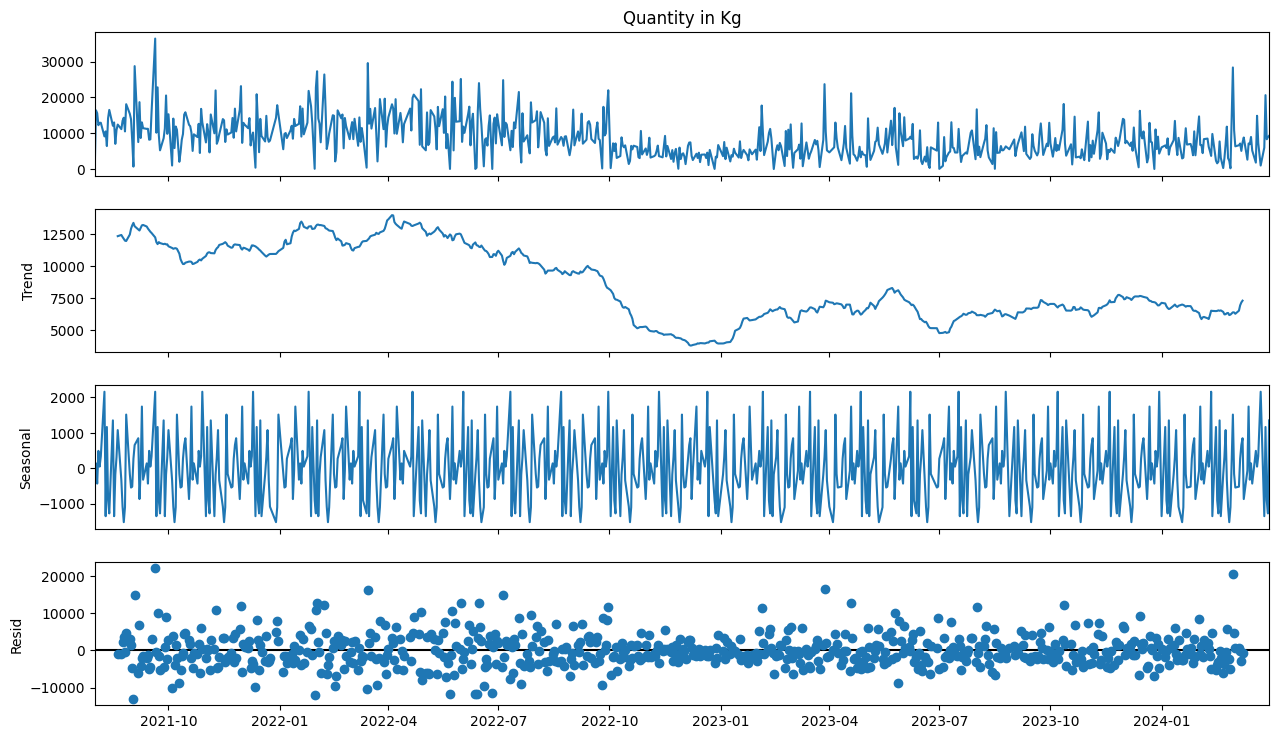

In [5]:
sea_aggregated_data.set_index('Date', inplace=True)
decomposition = seasonal_decompose(sea_aggregated_data['Quantity in Kg'], model='additive', period=30)
# Plotting the decomposed components
fig = decomposition.plot()
fig.set_size_inches(14, 8)
plt.show()

In [13]:
# Using auto_arima to find the best ARIMA model parameters
auto_model = auto_arima(sea_aggregated_data['Quantity in Kg'], seasonal=True, m=12, trace=True,
                        error_action='ignore', suppress_warnings=True, stepwise=True)

auto_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=13880.046, Time=1.64 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=14351.969, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=14155.940, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=13875.639, Time=1.08 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=14349.972, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=13875.648, Time=0.51 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=13877.757, Time=1.67 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=13888.663, Time=1.00 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=13887.840, Time=0.48 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=3.60 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=14350.743, Time=0.20 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=13888.708, Time=1.33 sec
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=13875.945, Time=2.47 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=14155.432, Time=0.30 sec
 ARIMA(1,1,

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  702
Model:             SARIMAX(0, 1, 1)x(0, 0, 1, 12)   Log Likelihood               -6934.050
Date:                            Fri, 10 May 2024   AIC                          13874.100
Time:                                    14:30:30   BIC                          13887.758
Sample:                                         0   HQIC                         13879.379
                                            - 702                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9499      0.013    -70.772      0.000      -0.976      -0.924
ma.S.L12      -0.0580      0.034     -1.694      0.090      -0.125       0.009
sigma2      2.281e+07   2.58e-10   8.85e+16      0.000    2.28e+07    2.28e+07
===================================================================================
Ljung-Box (L1) (Q):                   1.10   Jarque-Bera (JB):               251.45
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                             0.83
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.99e+32. Standard errors may be unstable.
"""

In [19]:
# Manually setting up a SARIMA model
# Initial guess for parameters: (p, d, q) and seasonal (P, D, Q, m)
p, d, q = 1, 1, 1  # Non-seasonal parameters
P, D, Q, m = 1, 1, 1, 12  # Seasonal parameters (assuming annual seasonality with monthly data)

# Fitting the SARIMA model
model = SARIMAX(sea_aggregated_data['Quantity in Kg'], order=(p, d, q), seasonal_order=(P, D, Q, m),
                enforce_stationarity=False, enforce_invertibility=False)
results = model.fit(disp=False)

# Summary of the model
results.summary()

c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                     Quantity in Kg   No. Observations:                  702
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -6793.982
Date:                            Fri, 10 May 2024   AIC                          13597.965
Time:                                    18:59:49   BIC                          13620.538
Sample:                                         0   HQIC                         13606.705
                                            - 702                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0486      0.092     -0.526      0.599      -0.230       0.132
ma.L1         -0.9064      0.043    -21.110      0.000      -0.991      -0.822
ar.S.L12      -0.0416      0.088     -0.475      0.635      -0.213       0.130
ma.S.L12      -0.9768      0.054    -18.174      0.000      -1.082      -0.871
sigma2      5.856e+07   2.09e-10    2.8e+17      0.000    5.86e+07    5.86e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               207.00
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                             0.67
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.79e+32. Standard errors may be unstable.
"""

c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\admin\AppData\Local\Temp\ipykernel_7780\429858401.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(sea_aggregated_data.index[-1], periods=forecast_steps + 1, freq='M')[1:],
C:\Users\admin\AppData\Local\Temp\ipykernel_7780\429858401.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.f

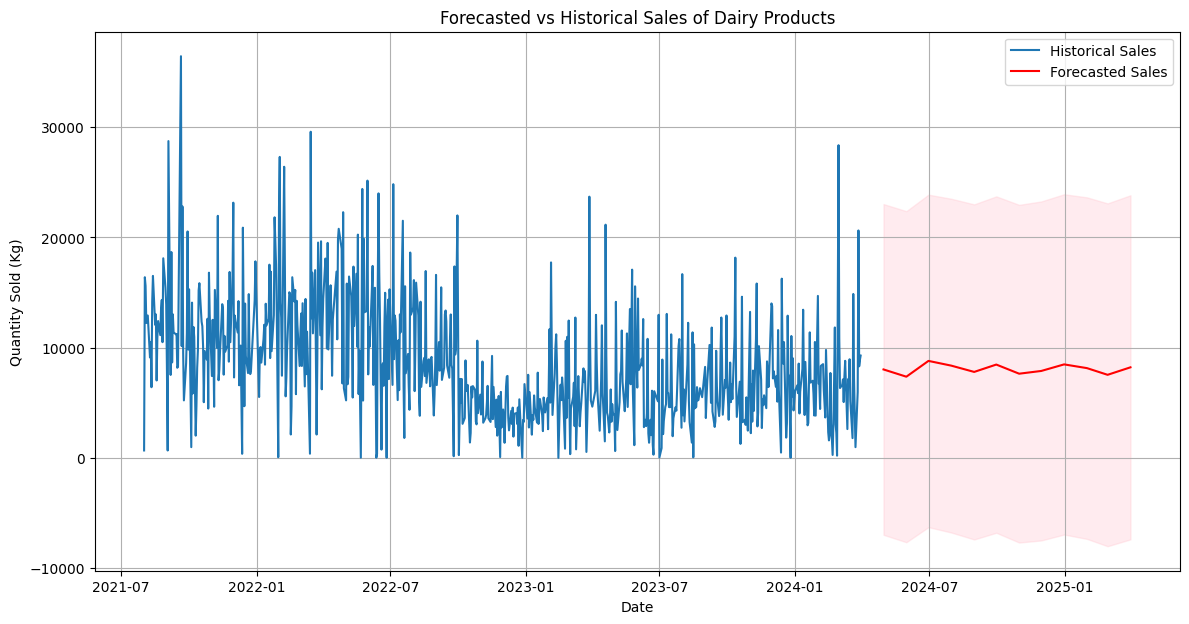

In [12]:
# Generating forecast for the next 12 months
forecast_steps = 12
forecast = results.get_forecast(steps=forecast_steps)
forecast_conf_int = forecast.conf_int()

# Plotting the forecast along with the historical data
plt.figure(figsize=(14, 7))
plt.plot(sea_aggregated_data.index, sea_aggregated_data['Quantity in Kg'], label='Historical Sales')
plt.plot(pd.date_range(sea_aggregated_data.index[-1], periods=forecast_steps + 1, freq='M')[1:], 
        forecast.predicted_mean, label='Forecasted Sales', color='red')
plt.fill_between(pd.date_range(sea_aggregated_data.index[-1], periods=forecast_steps + 1, freq='M')[1:], 
                forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Forecasted vs Historical Sales of Dairy Products')
plt.xlabel('Date')
plt.ylabel('Quantity Sold (Kg)')
plt.legend()
plt.grid(True)
plt.show()



## Correlation

In [20]:
# Assuming 'data' is your DataFrame
domestic_sales = df[df['Country of Origin'] == df['Sales in Country']]
international_sales = df[df['Country of Origin'] != df['Sales in Country']]

# To count the number of entries
domestic_count = domestic_sales.shape[0]
international_count = international_sales.shape[0]

print("Domestic sales count:", domestic_count)
print("International sales count:", international_count)

Domestic sales count: 9823
International sales count: 13211


In [31]:
print("Domestic sales quantity",domestic_sales['Quantity in Kg'].sum())
print("International sales quantity",international_sales['Quantity in Kg'].sum())

Domestic sales quantity 9828453.48656
International sales quantity 6185429.159693334


In [28]:
# Create contingency table
contingency_table = pd.crosstab(international_sales['Country of Origin'], international_sales['Sales in Country'])

# Perform Chi-square test
chi2, p, dof, _ = chi2_contingency(contingency_table)

# Calculate Cramér's V
n = contingency_table.sum().sum()  # Total observations
cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape)-1)))
print("Cramér's V:", cramers_v)

Cramér's V: 0.5567055788742794


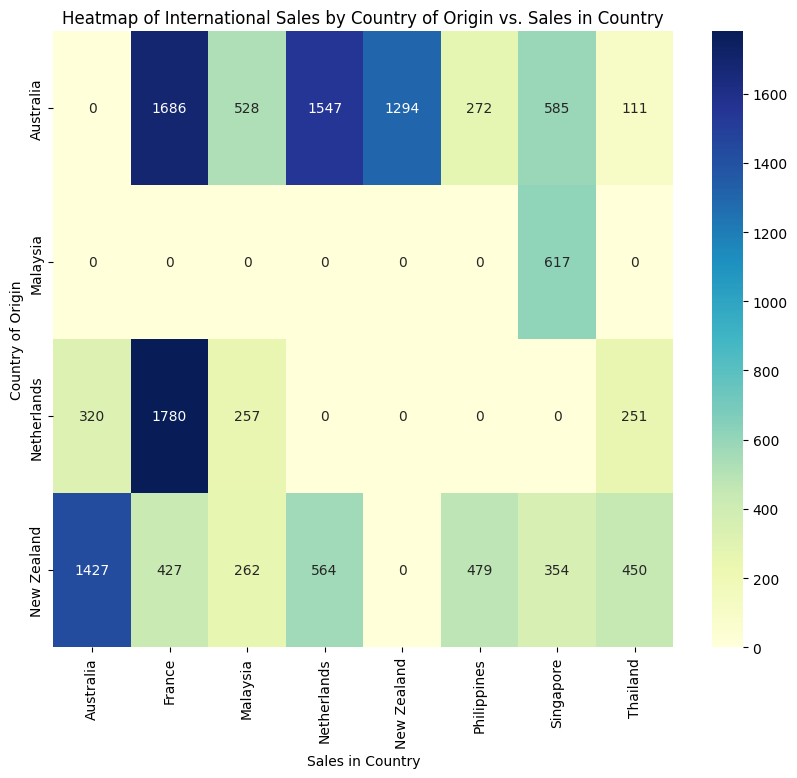

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generate heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(contingency_table, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Heatmap of International Sales by Country of Origin vs. Sales in Country')
plt.xlabel('Sales in Country')
plt.ylabel('Country of Origin')
plt.show()
